# DE and cluster analysis of samples S2 and S3

In [6]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.ClusterDE as cd

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

import warnings
warnings.filterwarnings("ignore")



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
import importlib

## Read data

In [23]:
data_s2 = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_processed.h5ad")
data_s3 = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")

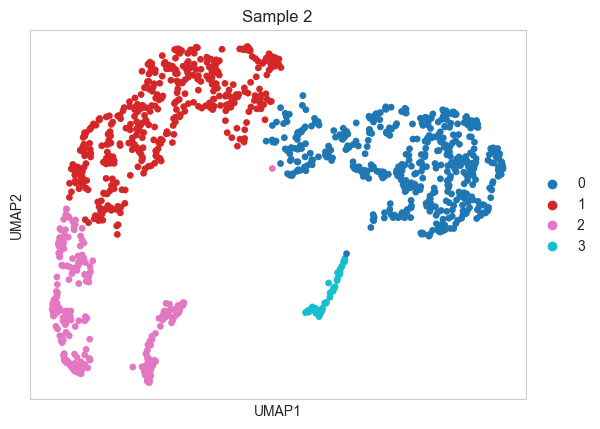

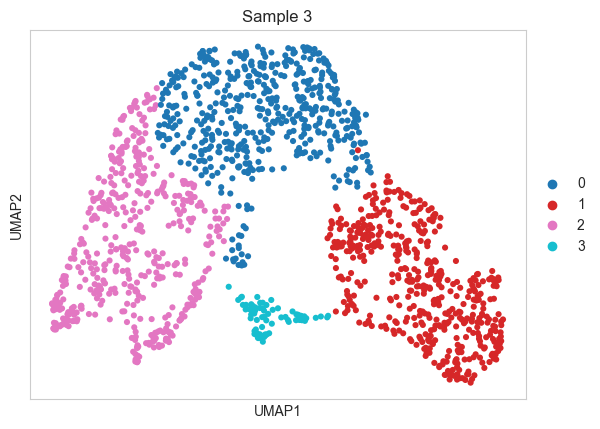

In [24]:
sc.pl.umap(data_s2, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()
sc.pl.umap(data_s3, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

### "old" cluster annotation 

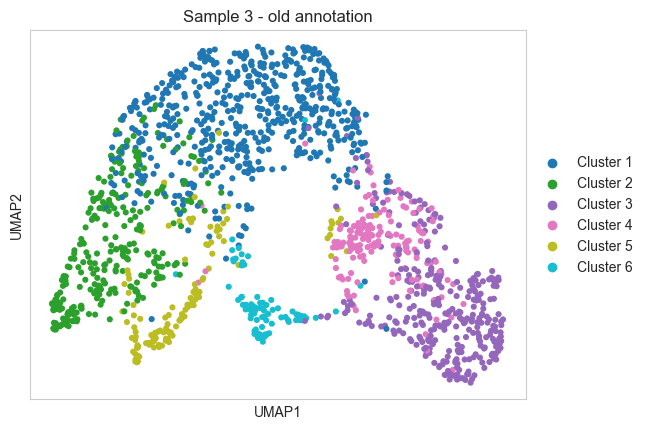

In [25]:
s3_graph_cluster = pd.read_csv("/Users/johannes.ostner/Documents/PhD/data/MOBA_scRNA/outs/outs_S3/Graph-Based.csv", index_col=0)

data_s3.obs["cluster_loupe"] = s3_graph_cluster["Graph-based"]
sc.pl.umap(data_s3, color="cluster_loupe", palette="tab10", title="Sample 3 - old annotation")
plt.show()

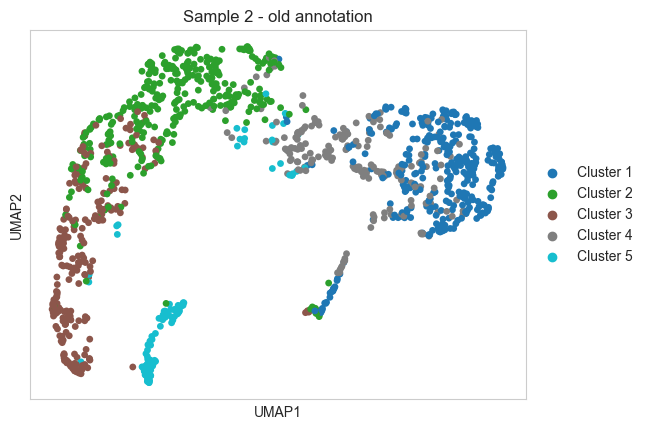

In [26]:
s2_graph_cluster = pd.read_csv("/Users/johannes.ostner/Documents/PhD/data/MOBA_scRNA/outs/outs_S2/Graph-Based.csv", index_col=0)

data_s2.obs["cluster_loupe"] = s2_graph_cluster["Graph-based"]
sc.pl.umap(data_s2, color="cluster_loupe", palette="tab10", title="Sample 2 - old annotation")
plt.show()

### Standard pipeline annotation

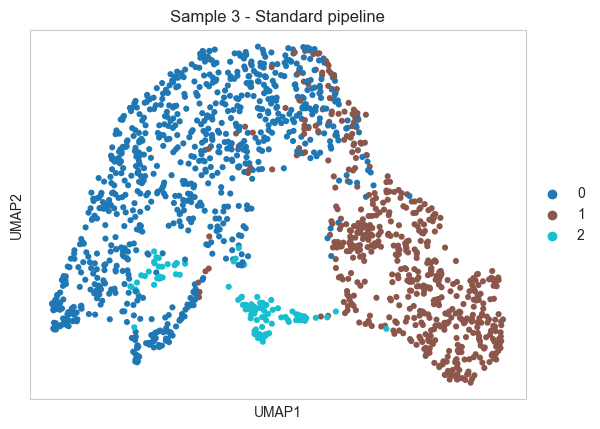

In [27]:
s3_standard = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_standard'.h5ad")

data_s3.obs["cluster_standard"] = s3_standard.obs["leiden_res_0.25"]
sc.pl.umap(data_s3, color="cluster_standard", palette="tab10", title="Sample 3 - Standard pipeline")
plt.show()

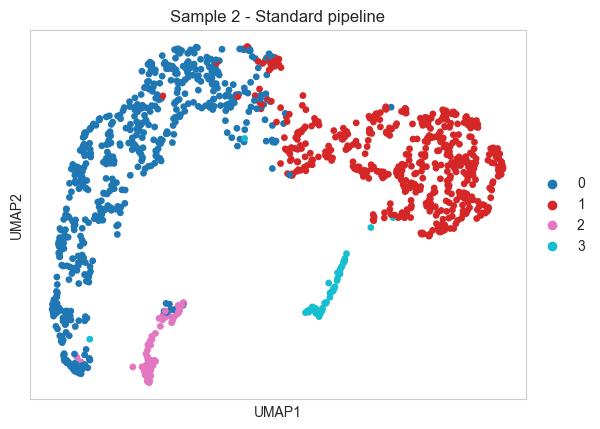

In [28]:
s2_standard = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_standard'.h5ad")

data_s2.obs["cluster_standard"] = s2_standard.obs["leiden_res_0.25"]
sc.pl.umap(data_s2, color="cluster_standard", palette="tab10", title="Sample 2 - Standard pipeline")
plt.show()

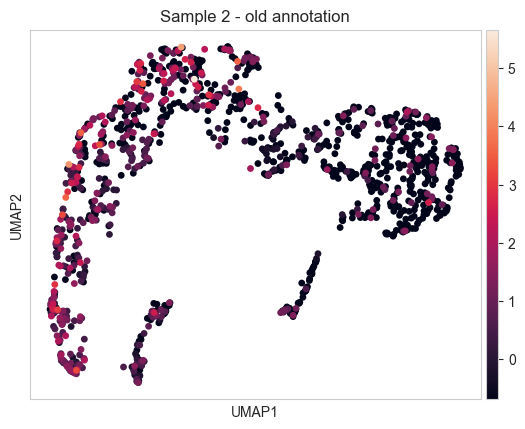

In [29]:
sc.pl.umap(data_s2, color="PA2201", palette="tab10", title="Sample 2 - old annotation")
plt.show()

## Differential expression testing with ClusterDE

### S3

In [30]:
data_s3

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'cluster_loupe', 'cluster_standard'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cluster_loupe_colors', 'cluster_standard_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [31]:
import tools.ClusterDE as cd
importlib.reload(cd)

<module 'tools.ClusterDE' from '/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py'>

Construct synthetic null

In [32]:
cd.construct_synthetic_null(data_s3, save_path="../../data/MOBA_scRNAseq/outs_S3/scdesign_synthetic_null")

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 05:03


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 02:12


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 07:05


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:09


R[write to console]: New Data Generating End

R[write to console]: Warning:
R[write to console]:  Overwriting previous file ../../data/MOBA_scRNAseq/outs_S3/scdesign_synthetic_null.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA



In [22]:

data_null_s3 = ad.AnnData()

In [109]:
%%R -o data_null_s3

suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(SeuratDisk))
data.null <- LoadH5Seurat("../../data/MOBA_scRNAseq/outs_S3/scdesign_synthetic_null.h5Seurat")
data_null_s3 <- as.SingleCellExperiment(data.null)

data_null_s3

class: SingleCellExperiment 
dim: 5553 1544 
metadata(0):
assays(2): counts logcounts
rownames(5553): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1544): AAACCCAGTGGACCTC-1 AAACCCATCCTGTAGA-1 ...
  TTTGGTTTCGTTGTGA-1 TTTGTTGAGTAATACG-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


Processing of Null data

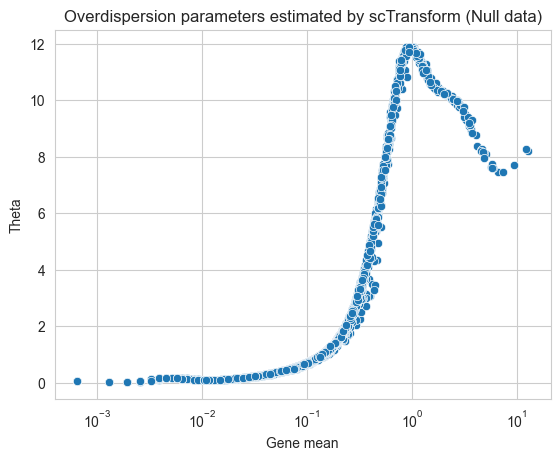

In [110]:
nb.estimate_overdisp_nb(data_null_s3)
data_null_s3.var["mean_counts"] = np.asarray(np.mean(data_null_s3.X, axis=0)).squeeze()
g = sns.scatterplot(data=data_null_s3.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform (Null data)")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [111]:
k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

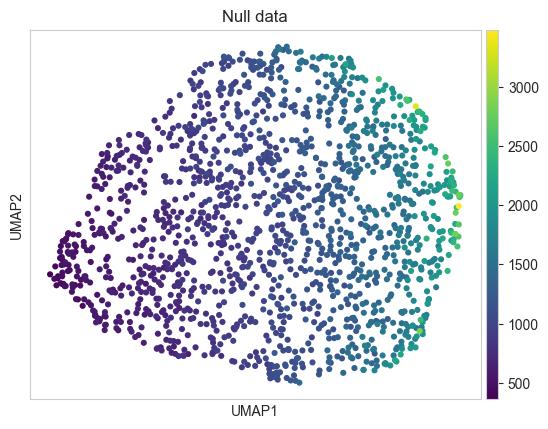

In [112]:
sc.pp.calculate_qc_metrics(data_null_s3, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_s3, target_sum=None, layer=None)
data_null_s3.X = sps.csr_matrix(np.log(data_null_s3.X.toarray() + np.array(data_null_s3.var["nb_overdisp_cutoff"] / 4)))
data_null_s3.layers["vst_counts"] = data_null_s3.X.copy()
sc.pp.scale(data_null_s3, max_value=10, zero_center=True)
data_null_s3.X[np.isnan(data_null_s3.X)] = 0
sc.tl.pca(data_null_s3, svd_solver='arpack')
sc.pp.neighbors(data_null_s3, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_s3, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_s3, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

Cluster such that 2 clusters are generated

Resolution for two clusters: 0.09999999999999999


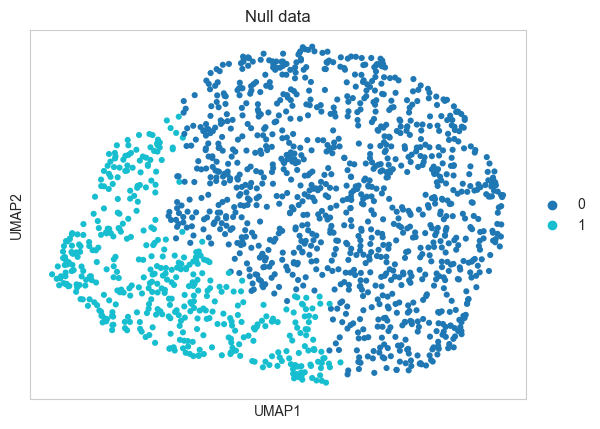

In [284]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_s3, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_s3.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")
sc.pl.umap(data_null_s3, color="leiden", palette="tab10", title="Null data")
plt.show()

In [285]:
sc.tl.rank_genes_groups(data_null_s3, groupby='leiden', method='wilcoxon')
p_null_s3 = pd.DataFrame({"pval_null": [x[1] for x in data_null_s3.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_null_s3.uns["rank_genes_groups"]["names"]])

In [286]:
importlib.reload(cd)
clusters = data_s3.obs["leiden_opt"].unique()

DEs = {}
pvals = {}
fdr = 0.1

for c in clusters:
    print(c)
    data_s3.obs[f"is_cluster_{c}"] = ([x == c for x in data_s3.obs["leiden_opt"]])
    data_s3.obs[f"is_cluster_{c}"] = data_s3.obs[f"is_cluster_{c}"].astype("category")
    sc.tl.rank_genes_groups(data_s3, f'is_cluster_{c}', method='wilcoxon', key_added=f"rank_genes_groups_{c}")
    p_data = pd.DataFrame(
        {"pval_data": [x["True"] for x in data_s3.uns[f"rank_genes_groups_{c}"]["pvals"]]},
        index = [x["True"] for x in data_s3.uns[f"rank_genes_groups_{c}"]["names"]]
    )
    DE_TU, pval_TU = cd.call_de(p_data, p_null_s3, FDR=fdr, correct=True, nlog=True)
    data_s3.var[f"pval_cluster_{c}"] = pval_TU["pval_data"]
    data_s3.var[f"q_cluster_{c}"] = pval_TU["q"]
    data_s3.var[f"DE_cluster_{c}"] = (data_s3.var[f"q_cluster_{c}"] < fdr)
    
    DEs[c] = DE_TU
    pvals[c] = pval_TU

2
correcting...
1
correcting...
0
correcting...
3


In [306]:
c = "3"

pvals[c]

,pval_data,pval_null,cs,q
PA0624,42.992122,0.736938,42.255184,1.0
PA0636,42.827053,1.172759,41.654294,1.0
PA0622,41.173361,0.355248,40.818113,1.0
PA0621,39.838780,0.066711,39.772069,1.0
PA0635,38.280540,0.273196,38.007344,1.0
...,...,...,...,...
PA4932,1.315353,94.748756,-93.433402,1.0
PA4262,0.345179,94.730041,-94.384862,1.0
PA4264,0.105831,96.864075,-96.758244,1.0
PA4256,0.258697,103.040446,-102.781748,1.0


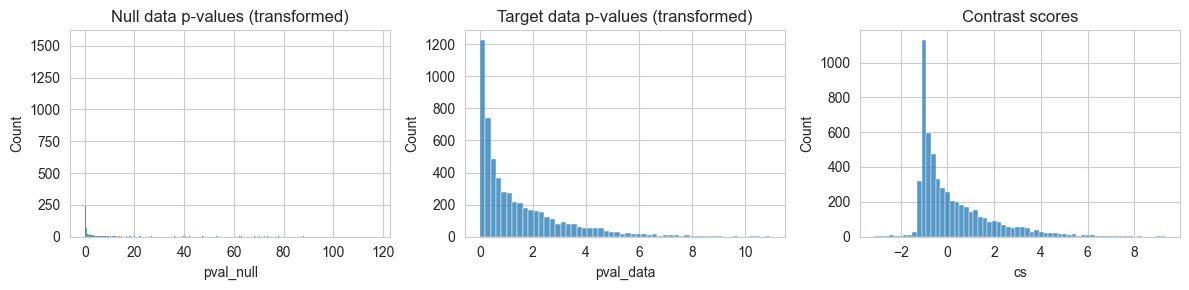

In [288]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(pvals[c], x="pval_null", ax=ax[0])
ax[0].set_title("Null data p-values (transformed)")
sns.histplot(pvals[c], x="pval_data", ax=ax[1])
ax[1].set_title("Target data p-values (transformed)")
sns.histplot(pvals[c], x="cs", ax=ax[2])
ax[2].set_title("Contrast scores")
plt.tight_layout()
plt.show()

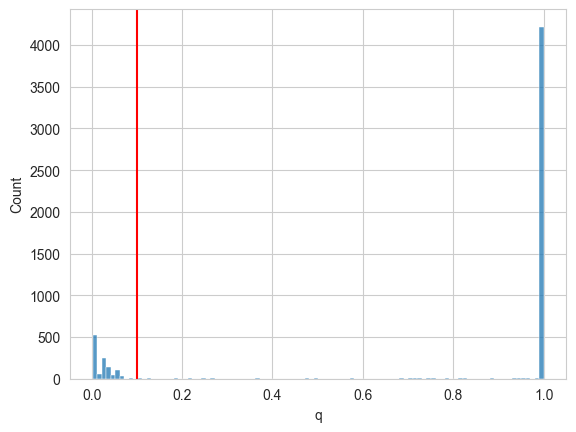

1181


In [289]:
sns.histplot(pvals[c], x="q", binwidth=0.01)
plt.axvline(fdr, color="red")
plt.show()

print(np.sum(data_s3.var[f"DE_cluster_{c}"]))

In [290]:
clusters_s3 = data_s3.obs["leiden_opt"].unique()
for c3 in clusters_s3:
    DE_s3 = data_s3.var[data_s3.var[f"DE_cluster_{c3}"]].index.tolist()
    print(f"Sample 3 - Cluster {c3}: {len(DE_s3)} DE genes")

Sample 3 - Cluster 2: 1181 DE genes
Sample 3 - Cluster 1: 52 DE genes
Sample 3 - Cluster 0: 32 DE genes
Sample 3 - Cluster 3: 0 DE genes


### S2

In [15]:
data_s2

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'cluster_loupe', 'cluster_standard'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap', 'cluster_loupe_colors', 'cluster_standard_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

Construct synthetic null

In [16]:
cd.construct_synthetic_null(data_s2, save_path="../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, row

  |=======================================================| 100%, Elapsed 04:55


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 02:14


R[write to console]: Converting End

R[write to console]: Copula group 1 starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 08:32


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:15


R[write to console]: New Data Generating End

R[write to console]: Warning:
R[write to console]:  Overwriting previous file ../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA



In [17]:
data_null_s2 = ad.AnnData()

In [18]:
%%R -o data_null_s2

suppressPackageStartupMessages(library(Seurat))
data.null <- LoadH5Seurat("../../data/MOBA_scRNAseq/outs_S2/scdesign_synthetic_null.h5Seurat")
data_null_s2 <- as.SingleCellExperiment(data.null)

data_null_s2

class: SingleCellExperiment 
dim: 5540 1255 
metadata(0):
assays(2): counts logcounts
rownames(5540): PA0001 PA0002 ... PA5569 PA5570
rowData names(0):
colnames(1255): AAACCCATCGGTGCAC-1 AAACGCTAGGCGCTTC-1 ...
  TTTGACTTCTTTACAC-1 TTTGTTGGTAGTGGCA-1
colData names(4): orig.ident nCount_RNA nFeature_RNA ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):


Validating h5Seurat file
Initializing RNA with data
Adding counts for RNA
Adding miscellaneous information for RNA
Adding command information
Adding cell-level metadata
Adding miscellaneous information
Adding tool-specific results


Processing of Null data

/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/johannes.ostner/Documents/PhD/BacSC/tools/scTransform.py:83: RuntimeWarning: invalid value encountered in divide
  t0 = n / sum(weights * (y / mu - 1) ** 2)


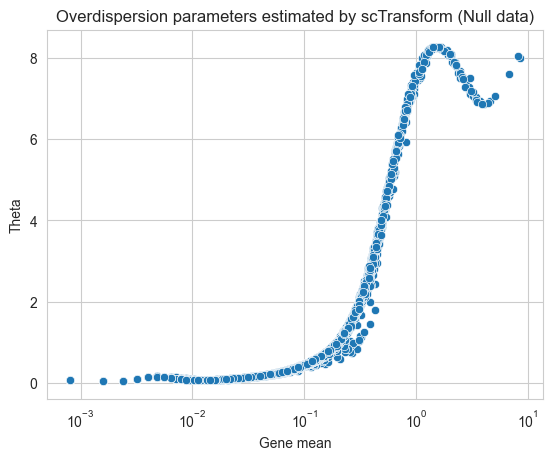

In [37]:
nb.estimate_overdisp_nb(data_null_s2)
data_null_s2.var["mean_counts"] = np.asarray(np.mean(data_null_s2.X, axis=0)).squeeze()
g = sns.scatterplot(data=data_null_s2.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform (Null data)")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [38]:
k_opt = 3
n_neighbors_opt = 30
min_dist_opt = 0.05
res_opt = 0.13

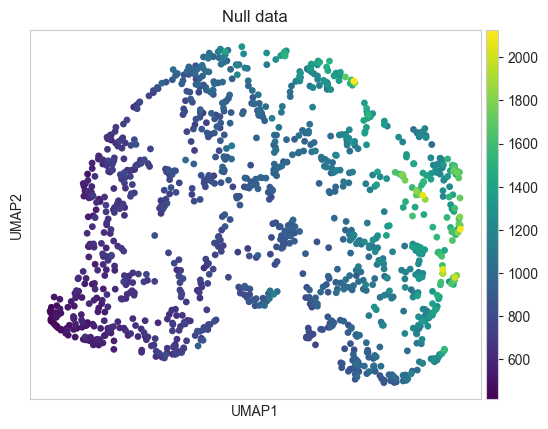

In [39]:
sc.pp.calculate_qc_metrics(data_null_s2, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_s2, target_sum=None, layer=None)
data_null_s2.X = sps.csr_matrix(np.log(data_null_s2.X.toarray() + np.array(data_null_s2.var["nb_overdisp_cutoff"] / 4)))
data_null_s2.layers["vst_counts"] = data_null_s2.X.copy()
sc.pp.scale(data_null_s2, max_value=10, zero_center=True)
data_null_s2.X[np.isnan(data_null_s2.X)] = 0
sc.tl.pca(data_null_s2, svd_solver='arpack')
sc.pp.neighbors(data_null_s2, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_s2, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_s2, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

Cluster such that 2 clusters are generated

Resolution for two clusters: 0.08


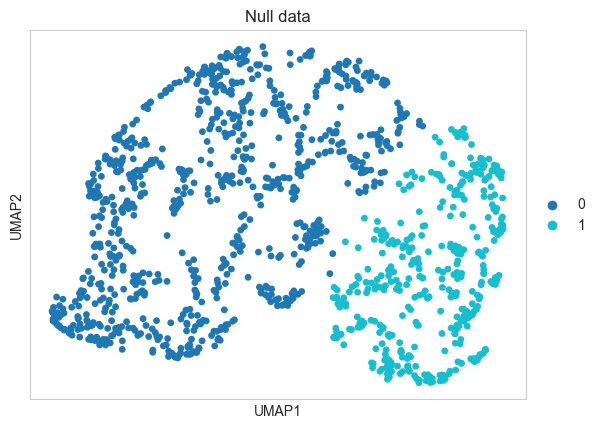

In [40]:
res2 = 0.05
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_s2, resolution=res2, key_added="leiden", random_state=1234)
    nclust = len(data_null_s2.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")
sc.pl.umap(data_null_s2, color="leiden", palette="tab10", title="Null data")
plt.show()

Test cluster 3 vs. Rest for S2 data - Wilcoxon test

In [72]:
sc.tl.rank_genes_groups(data_null_s2, groupby='leiden', method='wilcoxon')
p_null_s2 = pd.DataFrame({"pval_null": [x[1] for x in data_null_s2.uns["rank_genes_groups"]["pvals"]]}, index = [x[1] for x in data_null_s2.uns["rank_genes_groups"]["names"]])

Get p-values and do test adjustment

In [179]:
importlib.reload(cd)
clusters = data_s2.obs["leiden_opt"].unique()

DEs = {}
pvals = {}
fdr = 0.15

for c in clusters:
    print(c)
    data_s2.obs[f"is_cluster_{c}"] = ([x == c for x in data_s2.obs["leiden_opt"]])
    data_s2.obs[f"is_cluster_{c}"] = data_s2.obs[f"is_cluster_{c}"].astype("category")
    sc.tl.rank_genes_groups(data_s2, f'is_cluster_{c}', method='wilcoxon', key_added=f"rank_genes_groups_{c}")
    p_data = pd.DataFrame(
        {"pval_data": [x["True"] for x in data_s2.uns[f"rank_genes_groups_{c}"]["pvals"]]},
        index = [x["True"] for x in data_s2.uns[f"rank_genes_groups_{c}"]["names"]]
    )
    DE_TU, pval_TU = cd.call_de(p_data, p_null_s2, FDR=fdr, correct=True, nlog=True)
    data_s2.var[f"pval_cluster_{c}"] = pval_TU["pval_data"]
    data_s2.var[f"q_cluster_{c}"] = pval_TU["q"]
    data_s2.var[f"DE_cluster_{c}"] = (data_s2.var[f"q_cluster_{c}"] < fdr)
    
    DEs[c] = DE_TU
    pvals[c] = pval_TU

0
correcting...
1
2
correcting...
3


In [180]:
c = ("3")

pvals[c]

,pval_data,pval_null,cs,q
PA0629,33.215915,0.156878,33.059037,0.083333
PA0622,32.838953,0.147476,32.691477,0.083333
PA0631,32.499440,0.042001,32.457438,0.083333
PA0628,32.273090,0.116481,32.156608,0.083333
PA0625,30.916158,0.105632,30.810526,0.083333
...,...,...,...,...
PA1787,0.132198,18.497240,-18.365042,1.000000
PA2201,2.063389,21.416936,-19.353547,1.000000
PA2647,0.576727,20.143393,-19.566666,1.000000
PA1838,0.392993,20.557965,-20.164972,1.000000


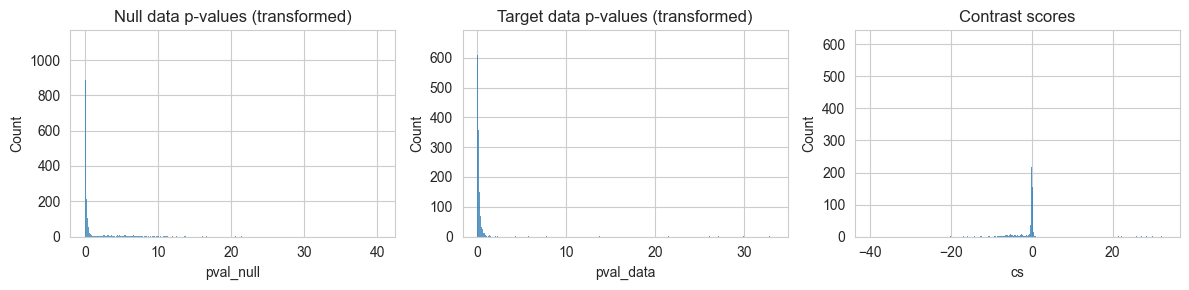

In [181]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(pvals[c], x="pval_null", ax=ax[0])
ax[0].set_title("Null data p-values (transformed)")
sns.histplot(pvals[c], x="pval_data", ax=ax[1])
ax[1].set_title("Target data p-values (transformed)")
sns.histplot(pvals[c], x="cs", ax=ax[2])
ax[2].set_title("Contrast scores")
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

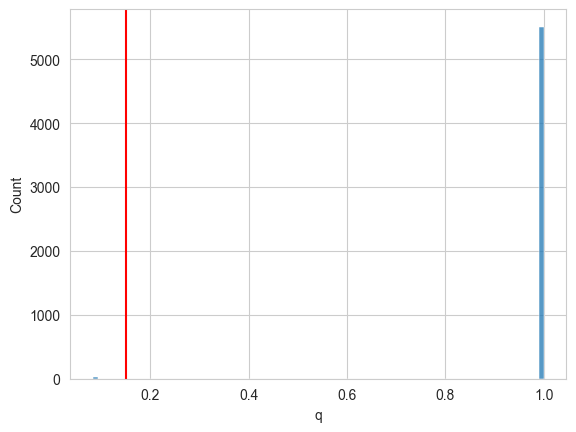

In [182]:
sns.histplot(pvals[c], x="q", binwidth=0.01)
plt.axvline(fdr, color="red")
plt.show

## Comparison of differentially expressed genes

### Matching clusters

In [183]:
data_s2.write_h5ad("../../data/MOBA_scRNAseq/outs_S2/filtered_data_maxpool_processed_DA.h5ad")
data_s3.write_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed_DA.h5ad")

In [184]:
clusters_s3 = data_s3.obs["leiden_opt"].unique()
clusters_s2 = data_s2.obs["leiden_opt"].unique()

s2_s3_overlap = pd.DataFrame(index=clusters_s2, columns=clusters_s3)

for c2 in clusters_s2:
    DE_s2 = data_s2.var[data_s2.var[f"DE_cluster_{c2}"]].index.tolist()
    for c3 in clusters_s3:
        DE_s3 = data_s3.var[data_s3.var[f"DE_cluster_{c3}"]].index.tolist()
        overlap = len(list(set(DE_s2) & set(DE_s3)))
        s2_s3_overlap.loc[c2, c3] = overlap
        
s2_s3_overlap
        

,2,1,0,3
0,160,23,65,0
1,2,14,19,0
2,67,23,59,0
3,24,0,0,0


In [185]:
for c2 in clusters_s2:
    DE_s2 = data_s2.var[data_s2.var[f"DE_cluster_{c2}"]].index.tolist()
    print(f"Sample 2 - Cluster {c2}: {len(DE_s2)} DE genes")
for c3 in clusters_s3:
    DE_s3 = data_s3.var[data_s3.var[f"DE_cluster_{c3}"]].index.tolist()
    print(f"Sample 3 - Cluster {c3}: {len(DE_s3)} DE genes")

Sample 2 - Cluster 0: 445 DE genes
Sample 2 - Cluster 1: 20 DE genes
Sample 2 - Cluster 2: 162 DE genes
Sample 2 - Cluster 3: 24 DE genes
Sample 3 - Cluster 2: 1206 DE genes
Sample 3 - Cluster 1: 23 DE genes
Sample 3 - Cluster 0: 66 DE genes
Sample 3 - Cluster 3: 0 DE genes


In [154]:
data_s3.var[data_s3.var[f"DE_cluster_2"]]

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,...,DE_cluster_2,pval_cluster_1,q_cluster_1,DE_cluster_1,pval_cluster_0,q_cluster_0,DE_cluster_0,pval_cluster_3,q_cluster_3,DE_cluster_3
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0022,Gene Expression,PA01,469,0.382124,0.323622,69.624352,590.0,6.381816,PA0022,14,...,True,0.180029,1.000000,False,9.974334,0.265762,False,0.897861,0.061805,False
PA0039,Gene Expression,PA01,359,0.312176,0.271687,76.748705,482.0,6.180017,PA0039,25,...,True,0.312770,1.000000,False,7.117602,0.265762,False,0.240977,1.000000,False
PA0055,Gene Expression,PA01,362,0.280440,0.247204,76.554404,433.0,6.073045,PA0055,40,...,True,0.450711,1.000000,False,2.877376,1.000000,False,0.224375,1.000000,False
PA0064,Gene Expression,PA01,382,0.297927,0.260769,75.259067,460.0,6.133398,PA0064,49,...,True,0.177626,1.000000,False,6.159323,0.265762,False,0.113610,1.000000,False
PA0085,Gene Expression,PA01,664,0.584845,0.460486,56.994819,903.0,6.806829,PA0085,58,...,True,0.975775,1.000000,False,2.515891,1.000000,False,0.030905,1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5528,Gene Expression,PA01,599,0.548575,0.437335,61.204663,847.0,6.742881,PA5528,3730,...,True,0.646587,1.000000,False,2.892996,1.000000,False,0.004167,1.000000,False
PA5530,Gene Expression,PA01,355,0.285622,0.251242,77.007772,441.0,6.091310,PA5530,3732,...,True,0.373160,1.000000,False,5.516486,0.265762,False,1.251208,0.042705,True
PA5549,Gene Expression,PA01,373,0.290803,0.255265,75.841969,449.0,6.109248,PA5549,3746,...,True,0.309572,1.000000,False,4.689484,0.265762,False,1.115598,0.046921,True


In [148]:
data_s2.uns

{'embedding_reliability_colors': array(['#1f77b4', '#ff7f0e', '#2ca02c'], dtype=object),
 'leiden': {'params': {'n_iterations': -1,
   'random_state': 0,
   'resolution': 0.13}},
 'leiden_opt_colors': ['#1f77b4', '#d62728', '#e377c2', '#17becf'],
 'neighbors': {'connectivities_key': 'connectivities',
  'distances_key': 'distances',
  'params': {'method': 'umap',
   'metric': 'euclidean',
   'n_neighbors': 30,
   'n_pcs': 3,
   'random_state': 0}},
 'pca': {'params': {'use_highly_variable': False, 'zero_center': True},
  'variance': array([99.77341373, 28.02532891, 26.59885138, 15.95019454, 12.37368272,
         10.93155947, 10.64688487, 10.50049602, 10.42555226, 10.18391237,
         10.05357944,  9.9287496 ,  9.88152906,  9.87129596,  9.79922289,
          9.75098848,  9.7184921 ,  9.63613178,  9.59968072,  9.57589814,
          9.52394865,  9.44505217,  9.42739365,  9.38346603,  9.34279114,
          9.30913532,  9.30613932,  9.28381483,  9.25113392,  9.211635  ,
          9.19096076

In [154]:
sc.tl.rank_genes_groups(data_s2, "leiden_opt", key_added="rank_genes_groups_test")
data_s2.uns["rank_genes_groups_3"]

{'params': {'groupby': 'is_cluster_3',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('PA3980', 'PA0629'), ('PA2201', 'PA0622'),
            ('PA1552.1', 'PA0631'), ..., ('PA0631', 'PA1552.1'),
            ('PA0622', 'PA2201'), ('PA0629', 'PA3980')],
           dtype=[('False', 'O'), ('True', 'O')]),
 'scores': rec.array([(  2.771563 , 12.145211 ), (  2.6259034, 12.074013 ),
            (  2.5996118, 12.009531 ), ..., (-12.009531 , -2.5996118),
            (-12.074013 , -2.6259034), (-12.145211 , -2.771563 )],
           dtype=[('False', '<f4'), ('True', '<f4')]),
 'pvals': rec.array([(5.57878650e-03, 6.08253360e-34),
            (8.64193307e-03, 1.44892999e-33),
            (9.33292789e-03, 3.16636129e-33), ...,
            (3.16636129e-33, 9.33292789e-03),
            (1.44892999e-33, 8.64193307e-03),
            (6.08253360e-34, 5.57878650e-03)],
           dtype=[('False', '<f8'), ('T

In [4]:
data_s2

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [5]:
data_export_s2 = ad.AnnData(
    X=data_s2.X.copy(),
    obs=data_s2.obs.loc[:, ["total_counts", "n_genes_by_counts", "leiden_opt"]],
    var=data_s2.var.loc[:, ["total_counts", "n_cells_by_counts", "TU_ID", "nb_overdisp_cutoff"]],
    uns={k: data_s2.uns[k] for k in ["leiden", "leiden_opt_colors", "neighbors", "pca", "umap"]},
    obsm=data_s2.obsm,
    varm=data_s2.varm,
    obsp=data_s2.obsp
)
data_export_s2

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

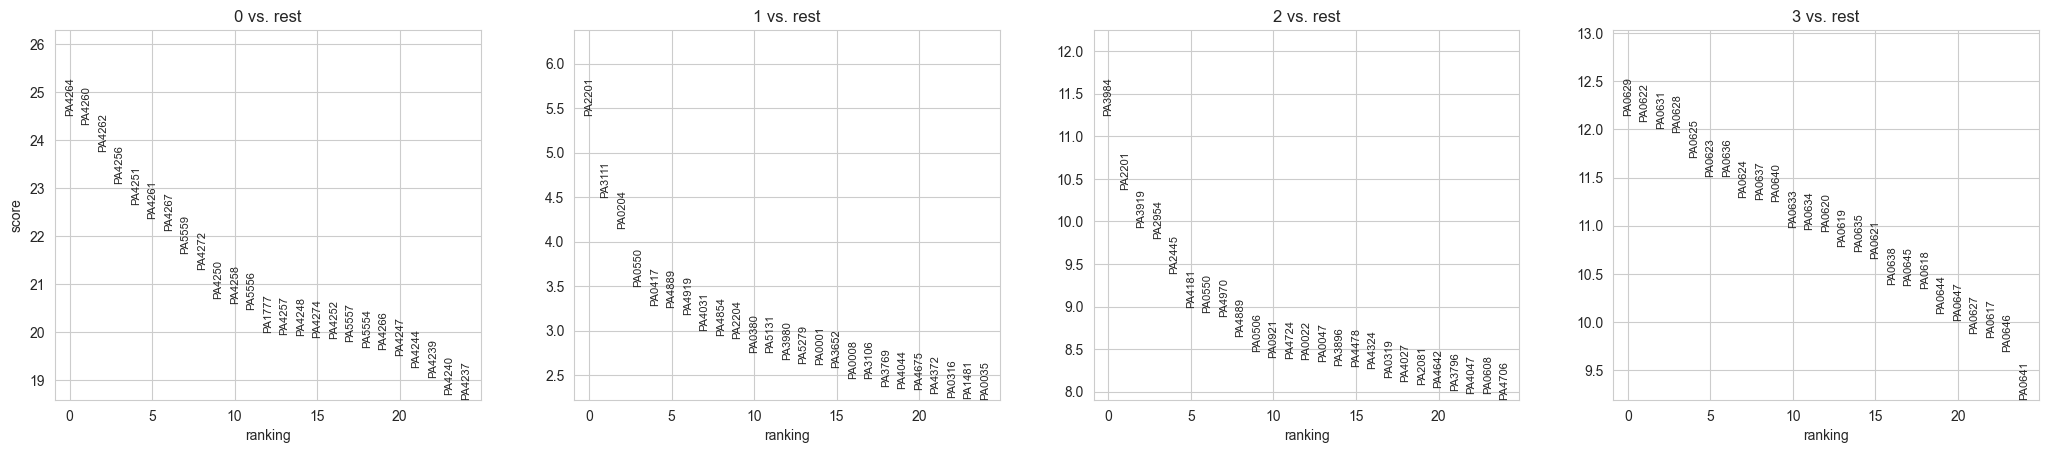

In [6]:
sc.tl.rank_genes_groups(data_export_s2, "leiden_opt", method="wilcoxon")
sc.pl.rank_genes_groups(data_export_s2, sharey=False, n_genes=25)

In [8]:
clusters = data_export_s2.obs["leiden_opt"].unique()

for c in clusters:
    p_data = pd.DataFrame(
        {"pval_data": [x[c] for x in data_export_s2.uns[f"rank_genes_groups"]["pvals"]]},
        index = [x[c] for x in data_export_s2.uns[f"rank_genes_groups"]["names"]]
    )
    data_export_s2.var[f"pval_cluster_{c}"] = p_data["pval_data"]
    
data_export_s2.var

,total_counts,n_cells_by_counts,TU_ID,nb_overdisp_cutoff,pval_cluster_0,pval_cluster_1,pval_cluster_2,pval_cluster_3
PAO1_ID,,,,,,,,
PA0001,665.0,508,1,10.393722,9.918909e-06,8.738045e-03,1.630383e-03,0.118978
PA0002,501.0,383,1,7.732892,2.573340e-07,1.212998e-01,3.696905e-07,0.324871
PA0003,914.0,604,1,11.745679,1.434730e-01,3.115313e-03,1.251073e-01,0.641383
PA0004,391.0,310,1,5.831478,9.330730e-04,4.431627e-01,5.375156e-07,0.878890
PA0005,130.0,108,2,1.360345,1.293042e-02,6.744661e-01,4.230306e-05,0.372600
...,...,...,...,...,...,...,...,...
PA5566,6.0,6,3750,0.061348,8.841548e-01,9.076161e-01,7.212241e-01,0.950420
PA5567,148.0,127,3751,1.643686,2.354024e-02,5.116530e-01,1.170417e-04,0.687505
PA5568,636.0,466,3752,9.819763,7.412569e-01,7.283312e-02,8.449529e-03,0.957146


In [9]:
data_export_s2.write_h5ad("../../data/MOBA_scRNAseq/outs_S2/export_s2.h5ad")

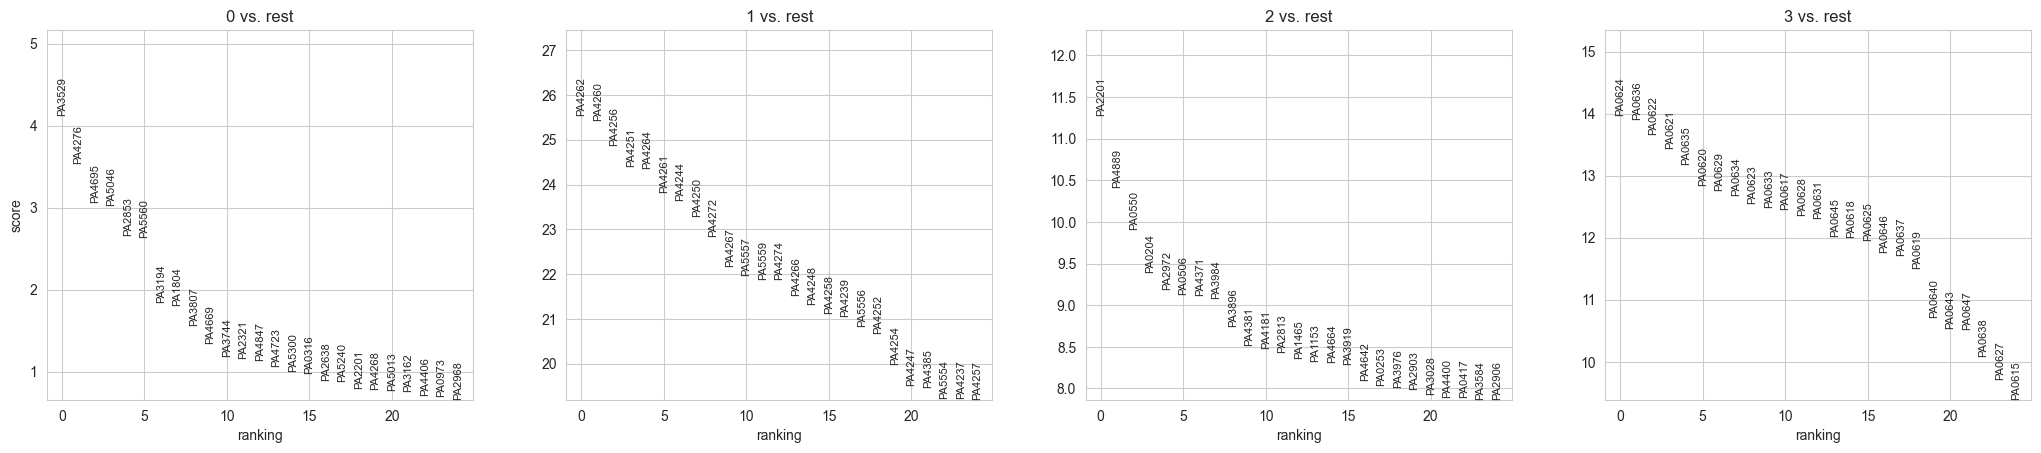

         total_counts  n_cells_by_counts  TU_ID  nb_overdisp_cutoff  \
PAO1_ID                                                               
PA0001         1029.0                735      1           18.026703   
PA0002          724.0                541      1           12.636576   
PA0003         1380.0                890      1           19.092684   
PA0004          577.0                463      1            9.982569   
PA0005          186.0                173      2            2.307159   
...               ...                ...    ...                 ...   
PA5566           15.0                 14   3750            0.123931   
PA5567          196.0                163   3751            2.323855   
PA5568         1019.0                740   3752           17.972356   
PA5569         5401.0               1430   3753            6.455157   
PA5570          721.0                480   3753           11.800244   

         pval_cluster_0  pval_cluster_1  pval_cluster_2  pval_cluster_3  
PA

In [22]:
data_export_s3 = ad.AnnData(
    X=data_s3.X.copy(),
    obs=data_s3.obs.loc[:, ["total_counts", "n_genes_by_counts", "leiden_opt"]],
    var=data_s3.var.loc[:, ["total_counts", "n_cells_by_counts", "TU_ID", "nb_overdisp_cutoff"]],
    uns={k: data_s3.uns[k] for k in ["leiden", "leiden_opt_colors", "neighbors", "pca", "umap"]},
    obsm=data_s3.obsm,
    varm=data_s3.varm,
    obsp=data_s3.obsp
)

sc.tl.rank_genes_groups(data_export_s3, "leiden_opt", method="wilcoxon")
sc.pl.rank_genes_groups(data_export_s3, sharey=False, n_genes=25)
clusters = data_export_s3.obs["leiden_opt"].unique()

for c in clusters:
    p_data = pd.DataFrame(
        {"pval_data": [x[c] for x in data_export_s3.uns[f"rank_genes_groups"]["pvals"]]},
        index=[x[c] for x in data_export_s3.uns[f"rank_genes_groups"]["names"]]
    )
    data_export_s3.var[f"pval_cluster_{c}"] = p_data["pval_data"]

print(data_export_s3.var)
data_export_s3.write_h5ad("../../data/MOBA_scRNAseq/outs_S3/export_s3.h5ad")